- This notebook will generate the contours of the spatial modules identified from each stereo-seq sample

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running this notebook on: ", device)
import sys
sys.path.append(r'./../../MERFISH_tools/spateo-release')

import spateo as st
print("Last run with spateo version:", st.__version__)

# Other imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
# import dynamo as dyn
import numpy as np

Running this notebook on:  cuda


/home/exx/.conda/envs/3D_Hippo_MERFISH_env/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/exx/.conda/envs/3D_Hippo_MERFISH_env/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/exx/.conda/envs/3D_Hippo_MERFISH_env/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than on

Last run with spateo version: 0.0.0


In [ ]:
%%time
adata_filtered= ad.read_h5ad('./../../Spatial_transcriptional_module_analysis/processed_data/chip34_5_11_intergrated_updatedfinal_10102025.h5ad')
adata_filtered

CPU times: user 10.5 s, sys: 2.11 s, total: 12.6 s
Wall time: 12.6 s


AnnData object with n_obs × n_vars = 3178572 × 72143
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag', 'Chip', 'x_aligned', 'y_aligned', 'Highlevel_spatialmodule', 'spatialmodule_GrayMatter_subclustered', 'spatialmodule_NAC_subclustered', 'spatialmodule_Caudate_subclustered', 'samples'
    var: 'Gene'
    obsm: 'cell_border', 'spatial', 'spatial_rotated'

- Utility function 

In [3]:
#### Extract the contour for selected spatial module.
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import morphology
from typing import Tuple,Union,List

def extract_cluster_contours_local(
    cluster_label_image: np.ndarray,
    cluster_labels: Union[int, List],
    bin_size: int,
    k_size: float = 2,
    erosion_size = 20,
    min_area: float = 9,
    close_kernel: int = cv2.MORPH_ELLIPSE,
    show: bool = True,
) -> Tuple[Tuple, np.ndarray, np.ndarray]:
    """Extract contour(s) for area(s) formed by buckets of the same spatial cluster.

    Args:
        cluster_label_image: the image that sets the pixels of the cluster of interests as the front color (background
            is 0).
        cluster_labels: The label value(s) of clusters of interests.
        bin_size: The size of the binning.
        k_size: Kernel size of the elliptic structuring element.
        min_area: Minimal area threshold corresponding to the resulting contour(s).
        close_kernel: The value to indicate the structuring element. By default, we use a circular structuring element.
        erosion_size: kernel size used to perform erosion operation 
        show: Visualize the result.

    Returns:
        contours: The Tuple coordinates of contours identified.
        cluster_image_close: The resultant image of the area of interest with small area removed.
        cluster_image_contour: The resultant image of the contour, generated from `cluster_image_close`.
    """

    import matplotlib.pyplot as plt
    import numpy as np
    import cv2
    from skimage import morphology

    k_size = int(k_size * bin_size)
    min_area = int(min_area * bin_size * bin_size)

    cluster_image_close = cluster_label_image.copy()
    if type(cluster_labels) == int:
        cluster_image_close = np.where(cluster_image_close == cluster_labels, cluster_image_close, 0)
    else:
        cluster_image_close = np.where(np.isin(cluster_image_close, cluster_labels), cluster_image_close, 0)

    kernal = cv2.getStructuringElement(close_kernel, (k_size, k_size))
    cluster_image_close = cv2.morphologyEx(cluster_image_close, cv2.MORPH_CLOSE, kernal)

    cluster_image_close = morphology.remove_small_objects(
        cluster_image_close.astype(bool),
        min_area,
        connectivity=2,
    ).astype(np.uint8)

    # Erosion  operation to avoid influence from neighboring regions 
    erosion_kernel = np.ones((erosion_size,erosion_size),np.uint8)
    cluster_image_close_eroded = cv2.erode(cluster_image_close,kernel=erosion_kernel, iterations=1)

    contours, _ = cv2.findContours(cluster_image_close_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cluster_image_contour = np.zeros((cluster_label_image.shape[0], cluster_label_image.shape[1]))
    for i in range(len(contours)):
        cv2.drawContours(cluster_image_contour, contours, i, i + 1, bin_size)

    return contours, cluster_image_close_eroded, cluster_image_contour


In [4]:
adata_filtered.uns['__type'] = 'UMI'

- Make sure the orgina of the spatial coordiante is at 0,0

In [5]:
XY_min = np.min(adata_filtered.obsm['spatial_rotated'],axis = 0,keepdims = True)
adata_filtered.obsm['spatial_rotated'] = adata_filtered.obsm['spatial_rotated'] - XY_min

In [6]:
adata_filtered.obs.columns

Index(['dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes',
       'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag',
       'NGenes_flag', 'molecule_gene_fold_change',
       'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange',
       'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI',
       'norm_TotalUMI_flag', 'Chip', 'x_aligned', 'y_aligned',
       'Highlevel_spatialmodule', 'spatialmodule_GrayMatter_subclustered',
       'spatialmodule_NAC_subclustered', 'spatialmodule_Caudate_subclustered',
       'samples'],
      dtype='object')

In [7]:
# replace the NAC-core with NAC-shel for chip
adata_filtered.obs['spatialmodule_NAC_subclustered'] = adata_filtered.obs['spatialmodule_NAC_subclustered'].replace({'NAC':'NAC_shell'})


In [8]:
# change the spatial module annotations into  numerical mapping values
module_annot_to_num = {nm:i for i,nm in enumerate(adata_filtered.obs['spatialmodule_NAC_subclustered'].unique())}
adata_filtered.obs['spatialmodule_NAC_subclustered_num'] = adata_filtered.obs['spatialmodule_NAC_subclustered'].replace(module_annot_to_num)


In [9]:
np.unique(adata_filtered.obs['spatialmodule_NAC_subclustered_num']),module_annot_to_num

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 {'Putamen': 0,
  'White_matter': 1,
  'Caudate': 2,
  'NAC_shell': 3,
  'ependymal_zone': 4,
  'NAC_core': 5,
  'VeP': 6,
  'white_matter': 7,
  'Gpe': 8})

- Extract the spatial module contours for each chip/sample

In [10]:
adata_filtered.obsm['X_spatial_rotated_downsampled'] = np.array(adata_filtered.obsm['spatial_rotated']//100).copy()

In [11]:
np.unique(adata_filtered.obs['samples'])

array(['chip11', 'chip34', 'chip5'], dtype=object)

1. Chip-34

In [12]:
adata_chip34 = adata_filtered[adata_filtered.obs['samples'].isin(['chip34'])]
adata_chip34

View of AnnData object with n_obs × n_vars = 1457666 × 72143
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag', 'Chip', 'x_aligned', 'y_aligned', 'Highlevel_spatialmodule', 'spatialmodule_GrayMatter_subclustered', 'spatialmodule_NAC_subclustered', 'spatialmodule_Caudate_subclustered', 'samples', 'spatialmodule_NAC_subclustered_num'
    var: 'Gene'
    uns: '__type'
    obsm: 'cell_border', 'spatial', 'spatial_rotated', 'X_spatial_rotated_downsampled'

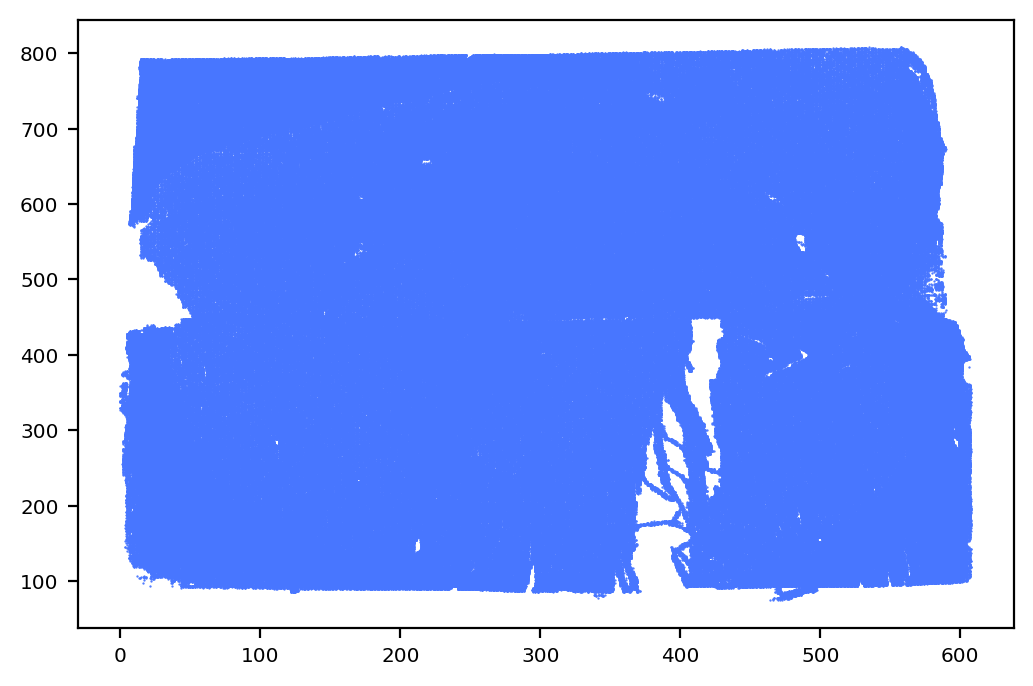

In [13]:
# make the orgina of the spatial coordiante at 0

plt.scatter(adata_chip34.obsm['X_spatial_rotated_downsampled'][:,0],adata_chip34.obsm['X_spatial_rotated_downsampled'][:,1], s = 0.1)
plt.show()

In [25]:
import cv2
module_contour = {}
for moduleID in np.unique(adata_chip34.obs['spatialmodule_NAC_subclustered']):
    cluster_label_image_lowres = st.dd.gen_cluster_image(adata_chip34,bin_size=1,spatial_key='X_spatial_rotated_downsampled',cluster_key = 'spatialmodule_NAC_subclustered_num',show=False)
    cluster_label_list = np.unique(adata_chip34[adata_chip34.obs['spatialmodule_NAC_subclustered_num'].isin([module_annot_to_num[moduleID]]),:].obs['cluster_img_label'])
    contours, cluster_image_close, cluster_image_contour = extract_cluster_contours_local(cluster_label_image_lowres,cluster_label_list,bin_size=1,k_size=30,show=False, erosion_size = 5)
    # filter noisy contours 
    contours = [np.squeeze(cnt) for cnt in contours if np.squeeze(cnt).ndim>1]
    if moduleID == 'ependymal_zone':
        module_contour[moduleID] = contours
    else:
        # only keep the larges contour 
        argmax = np.argmax([cv2.contourArea(cnt) for cnt in contours])
        module_contour[moduleID] = np.squeeze(contours[argmax])
        print(f'Print done with ....{moduleID}')
        

|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
Print done with ....Caudate
|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
Print done with ....NAC_shell
|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
Print done with ....Putamen
|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cl

In [26]:
module_contour.keys()

dict_keys(['Caudate', 'NAC_shell', 'Putamen', 'White_matter', 'ependymal_zone'])

- Check the detection of the contours/ overlap them on the spatial plot

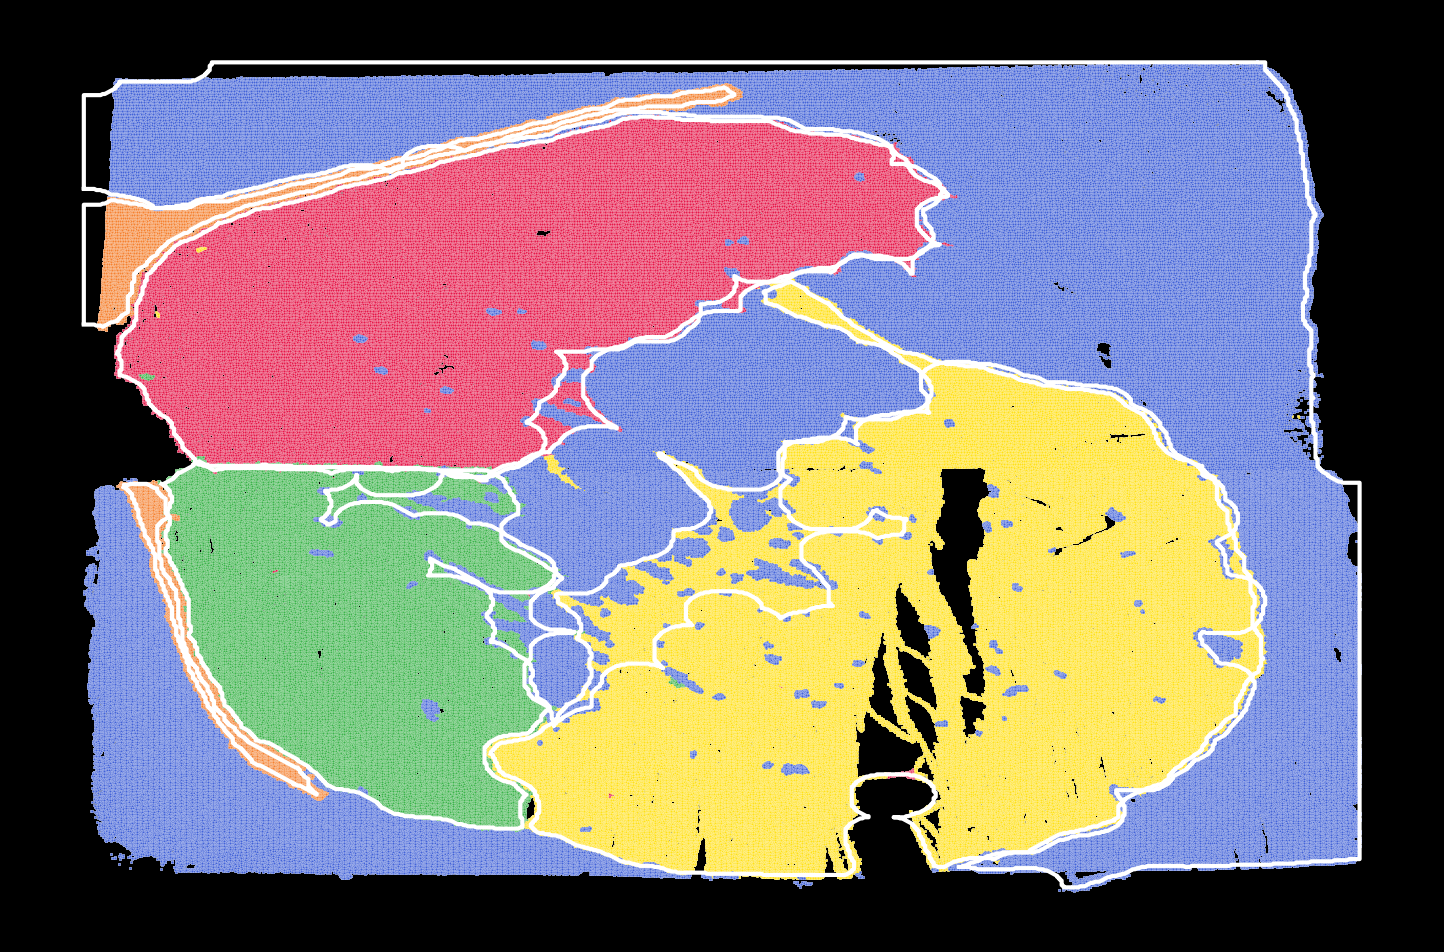

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
XN = np.array(adata_chip34.obsm['spatial_rotated'])
# XN = XN - XN.min(axis=0)
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]
color_map = {ld:cmap[i%len(cmap)] for i,ld in enumerate(adata_chip34.obs['spatialmodule_NAC_subclustered'].cat.categories)}
leiden = adata_chip34.obs['spatialmodule_NAC_subclustered']
fig,ax = plt.subplots(1,1,dpi=100,facecolor='k',figsize = (9,6))
sns.scatterplot(x = XN[:,0],y = XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    cnt_temp = [module_contour[ld]] if not isinstance(module_contour[ld],list) else module_contour[ld]
    for cnt in cnt_temp:
        cnt = cnt*100
        plt.plot(cnt[:,1],cnt[:,0], c = 'w')

# ax.invert_yaxis()
ax.set_axis_off()
plt.show()

undo the transformation and Save the result for the coordinates of each spatia modules 

In [28]:
for label in module_contour:
    if isinstance(module_contour[label],list):
        module_contour[label] = [100*(cnt) + XY_min[:,::-1] for cnt in module_contour[label]]
    else:
        module_contour[label] = 100*(module_contour[label]) + XY_min[:,::-1]


In [ ]:
np.save('./../../Spatial_transcriptional_module_analysis/processed_data/Chip34_contour_coords.npy',module_contour,allow_pickle = True)

2. Chip-5

In [30]:
adata_chip5 = adata_filtered[adata_filtered.obs['samples'].isin(['chip5'])]
adata_chip5

View of AnnData object with n_obs × n_vars = 810556 × 72143
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag', 'Chip', 'x_aligned', 'y_aligned', 'Highlevel_spatialmodule', 'spatialmodule_GrayMatter_subclustered', 'spatialmodule_NAC_subclustered', 'spatialmodule_Caudate_subclustered', 'samples', 'spatialmodule_NAC_subclustered_num'
    var: 'Gene'
    uns: '__type'
    obsm: 'cell_border', 'spatial', 'spatial_rotated', 'X_spatial_rotated_downsampled'

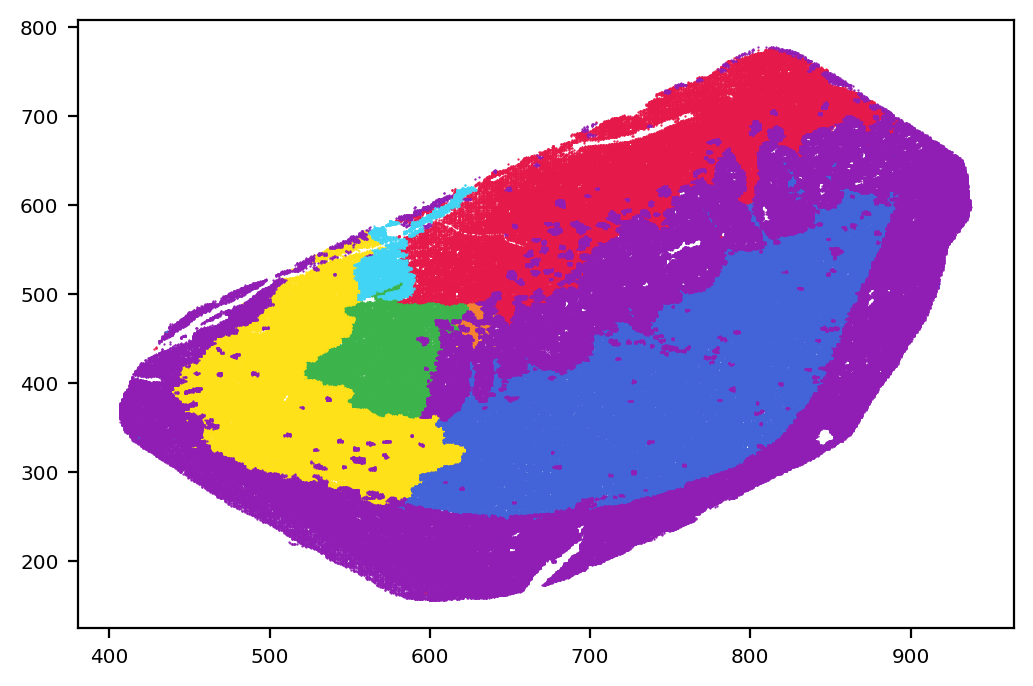

In [31]:
# make the orgina of the spatial coordiante at 0
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]
for moduleID ,clr in zip(np.unique(adata_chip5.obs['spatialmodule_NAC_subclustered']),cmap):
    keep = adata_chip5.obs['spatialmodule_NAC_subclustered'] == moduleID
    plt.scatter(adata_chip5[keep].obsm['X_spatial_rotated_downsampled'][:,0],adata_chip5[keep].obsm['X_spatial_rotated_downsampled'][:,1], s = 0.1,c  = clr)
plt.show()

In [32]:
np.unique(adata_chip5.obs['spatialmodule_NAC_subclustered'])

array(['Caudate', 'NAC_core', 'NAC_shell', 'Putamen', 'VeP',
       'White_matter', 'ependymal_zone'], dtype=object)

In [33]:
import cv2
module_contour = {}
for moduleID in np.unique(adata_chip5.obs['spatialmodule_NAC_subclustered']):
    try:
        cluster_label_image_lowres = st.dd.gen_cluster_image(adata_chip5,bin_size=1,spatial_key='X_spatial_rotated_downsampled',cluster_key = 'spatialmodule_NAC_subclustered_num',show=False)
        cluster_label_list = np.unique(adata_chip5[adata_chip5.obs['spatialmodule_NAC_subclustered_num'].isin([module_annot_to_num[moduleID]]),:].obs['cluster_img_label'])
        contours, cluster_image_close, cluster_image_contour = extract_cluster_contours_local(cluster_label_image_lowres,cluster_label_list,bin_size=1,k_size=30,show=False,erosion_size = 5)
        # filter noisy contours 
        contours = [np.squeeze(cnt) for cnt in contours if np.squeeze(cnt).ndim>1]
        # only keep the larges contour 
        argmax = np.argmax([cv2.contourArea(cnt) for cnt in contours])
        module_contour[moduleID] = np.squeeze(contours[argmax])
        print(f'Print done with ....{moduleID}')
    except:
        print(f'Failed at {moduleID}')
    

|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
Print done with ....Caudate
|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
Print done with ....NAC_core
|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
Print done with ....NAC_shell
|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding c

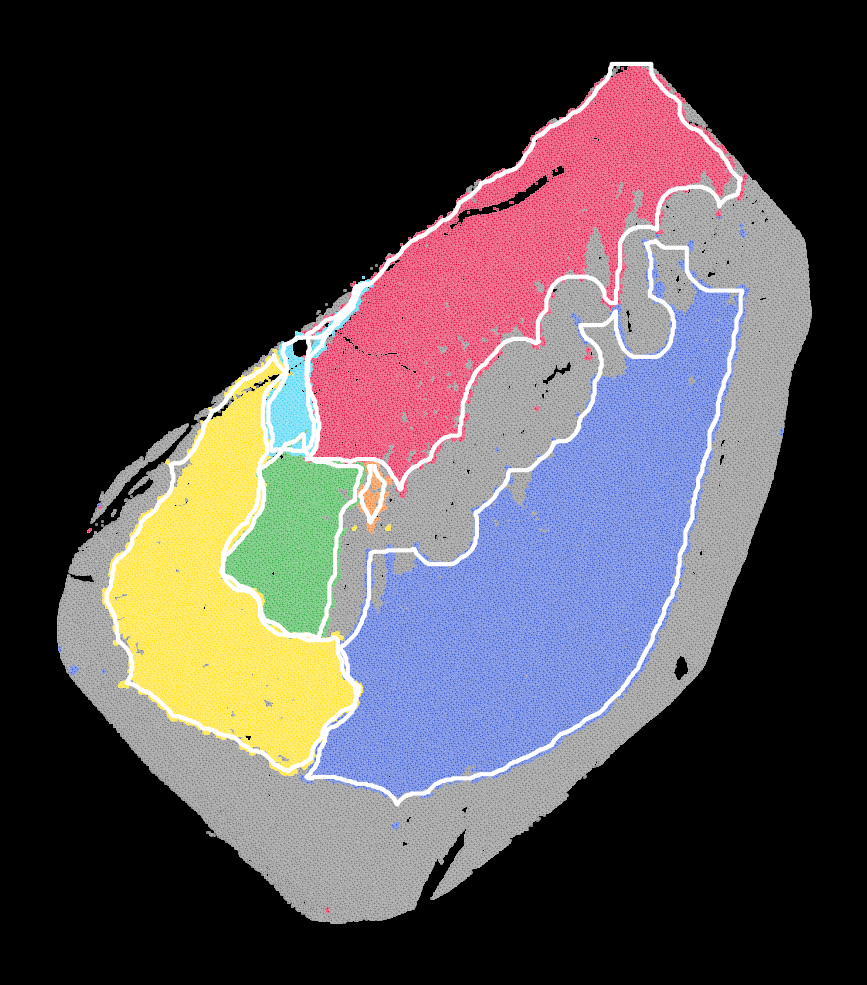

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
XN = np.array(adata_chip5.obsm['spatial_rotated'])
# XN = XN - XN.min(axis=0)
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]
color_map = {ld:cmap[i%len(cmap)] for i,ld in enumerate(adata_chip5.obs['spatialmodule_NAC_subclustered'].cat.categories)}
leiden = adata_chip5.obs['spatialmodule_NAC_subclustered']
dx,dy = np.ptp(XN,axis = 0)
fig,ax = plt.subplots(1,1,dpi=100,facecolor='k',figsize = (dx/1e4,dy/1e4))
sns.scatterplot(x = XN[:,0],y = XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    if ld == 'White_matter' :
        continue 
    if ld in module_contour:
        sns.scatterplot(x = XN[leiden==ld,0],y = XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
        temp = module_contour[ld]*100
        plt.plot(temp[:,1],temp[:,0], c = 'w')

# ax.invert_yaxis()
ax.set_axis_off()
plt.show()

In [35]:
for label in module_contour:
    if isinstance(module_contour[label],list):
        module_contour[label] = [100*(cnt) + XY_min[:,::-1] for cnt in module_contour[label]]
    else:
        module_contour[label] = 100*(module_contour[label]) + XY_min[:,::-1]

In [ ]:
# save result 
np.save('./../../Spatial_transcriptional_module_analysis/processed_data/Chip5_contour_coords.npy',module_contour,allow_pickle = True)

- Chip 11:

In [37]:
adata_chip11 = adata_filtered[adata_filtered.obs['samples'].isin(['chip11'])]
adata_chip11

View of AnnData object with n_obs × n_vars = 910350 × 72143
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag', 'Chip', 'x_aligned', 'y_aligned', 'Highlevel_spatialmodule', 'spatialmodule_GrayMatter_subclustered', 'spatialmodule_NAC_subclustered', 'spatialmodule_Caudate_subclustered', 'samples', 'spatialmodule_NAC_subclustered_num'
    var: 'Gene'
    uns: '__type'
    obsm: 'cell_border', 'spatial', 'spatial_rotated', 'X_spatial_rotated_downsampled'

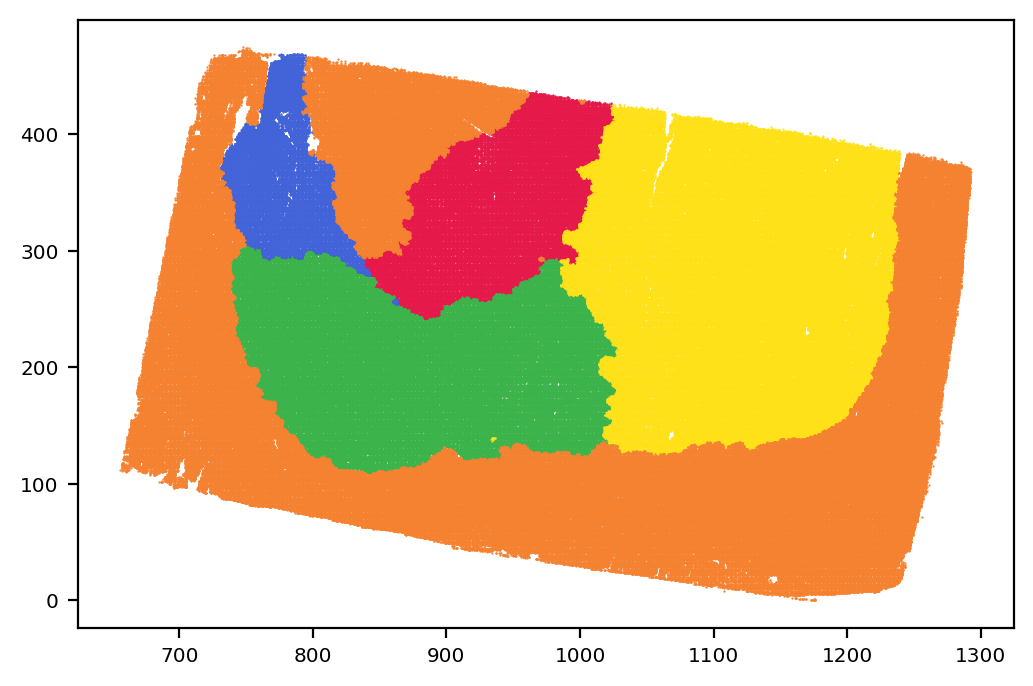

In [38]:
# make the orgina of the spatial coordiante at 0
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]
for moduleID ,clr in zip(np.unique(adata_chip11.obs['spatialmodule_NAC_subclustered']),cmap):
    keep = adata_chip11.obs['spatialmodule_NAC_subclustered'] == moduleID
    plt.scatter(adata_chip11[keep].obsm['X_spatial_rotated_downsampled'][:,0],adata_chip11[keep].obsm['X_spatial_rotated_downsampled'][:,1], s = 0.1,c  = clr)
plt.show()

In [39]:
np.unique(adata_chip11.obs['spatialmodule_NAC_subclustered'])

array(['Gpe', 'NAC_shell', 'Putamen', 'ependymal_zone', 'white_matter'],
      dtype=object)

In [40]:
import cv2
module_contour = {}
for moduleID in np.unique(adata_chip11.obs['spatialmodule_NAC_subclustered']):
    try:
        cluster_label_image_lowres = st.dd.gen_cluster_image(adata_chip11,bin_size=1,spatial_key='X_spatial_rotated_downsampled',cluster_key = 'spatialmodule_NAC_subclustered_num',show=False)
        cluster_label_list = np.unique(adata_chip11[adata_chip11.obs['spatialmodule_NAC_subclustered_num'].isin([module_annot_to_num[moduleID]]),:].obs['cluster_img_label'])
        contours, cluster_image_close, cluster_image_contour = extract_cluster_contours_local(cluster_label_image_lowres,cluster_label_list,bin_size=1,k_size=30,show=False,erosion_size = 5)
        # filter noisy contours 
        contours = [np.squeeze(cnt) for cnt in contours if np.squeeze(cnt).ndim>1]
        # only keep the larges contour 
        argmax = np.argmax([cv2.contourArea(cnt) for cnt in contours])
        module_contour[moduleID] = np.squeeze(contours[argmax])
        print(f'Print done with ....{moduleID}')
    except:
        print(f'Failed at {moduleID}')
    

|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
Print done with ....Gpe
|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
Print done with ....NAC_shell
|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
Print done with ....Putamen
|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluste

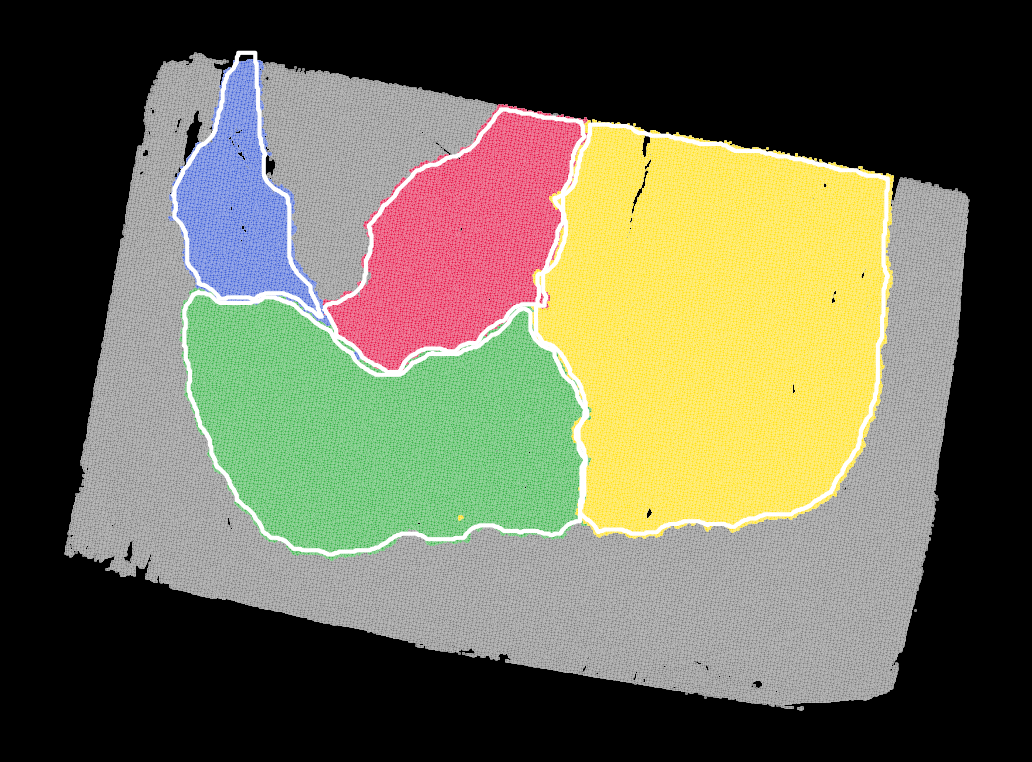

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
XN = np.array(adata_chip11.obsm['spatial_rotated'])
# XN = XN - XN.min(axis=0)
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]
color_map = {ld:cmap[i%len(cmap)] for i,ld in enumerate(adata_chip11.obs['spatialmodule_NAC_subclustered'].cat.categories)}
leiden = adata_chip11.obs['spatialmodule_NAC_subclustered']
dx,dy = np.ptp(XN,axis = 0)
fig,ax = plt.subplots(1,1,dpi=100,facecolor='k',figsize = (dx/1e4,dy/1e4))
sns.scatterplot(x = XN[:,0],y = XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    if ld == 'white_matter' :
        continue 
    if ld in module_contour:
        sns.scatterplot(x = XN[leiden==ld,0],y = XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
        temp = module_contour[ld]*100
        plt.plot(temp[:,1],temp[:,0], c = 'w')

# ax.invert_yaxis()
ax.set_axis_off()
plt.show()

In [42]:
for label in module_contour:
    if isinstance(module_contour[label],list):
        module_contour[label] = [100*(cnt) + XY_min[:,::-1] for cnt in module_contour[label]]
    else:
        module_contour[label] = 100*(module_contour[label]) + XY_min[:,::-1]

In [ ]:
# save result 
np.save('./../../Spatial_transcriptional_module_analysis/processed_data/Chip11_contour_coords.npy',module_contour,allow_pickle = True)